In [1]:
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import models
import optim
from engine import Value
from losses import cross_entropy

In [2]:
def make_dataset_gaussians():
    mean = [0., 0.]
    cov = [[2., 0.], [0., 2.]]
    num_points = 100
    X_0 = np.random.multivariate_normal(mean, cov, size=(num_points))
    y_0 = np.ones((len(X_0), 3)) * np.asarray([1, 0, 0])
    
    mean = [4., 4.]
    cov = [[2., 0.], [0., 2.]]
    X_1 = np.random.multivariate_normal(mean, cov, size=(num_points))
    y_1 = np.ones((len(X_1), 3)) * np.asarray([0, 1, 0])
    
    mean = [-3., -5.]
    cov = [[2., 0.], [0., 2.]]
    X_2 = np.random.multivariate_normal(mean, cov, size=(num_points))
    y_2 = np.ones((len(X_2), 3)) * np.asarray([0, 0, 1])
    
    X = np.concat([X_0, X_1, X_2])
    y = np.concat([y_0, y_1, y_2])
    
    print(f"X.shape={X.shape}, y.shape={y.shape}")
    show_viz(X, y)
    
    return X, y
    
def show_viz(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.8)
    plt.xlim((-12, 12))
    plt.ylim((-12, 12))
    plt.grid()
    plt.vlines(0, -15, 15, colors="k", linewidth=0.8)
    plt.hlines(0, -15, 15, colors="k", linewidth=0.8)
    plt.show()

X.shape=(300, 2), y.shape=(300, 3)


C:\Users\ES00200711\AppData\Local\Temp\ipykernel_49652\632056944.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.8)


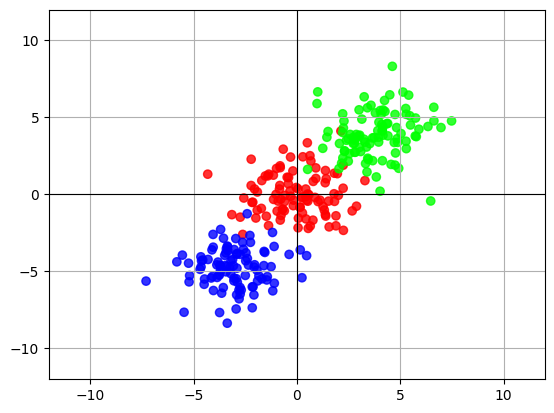

3 47


In [29]:
X, y = make_dataset_gaussians()

y = y.tolist()

mean = X.mean(axis=0)
std = X.std(axis=0) + 1e-8
X_norm = (X - mean) / std

X_norm = X_norm.tolist()

nn = models.MLP([2, 4, 4, 3], act_funcs=["relu", "relu", "softmax"], biases=[True, True, True])
print(len(nn.layers), len(nn.parameters()))
optimizer = optim.AdamW(nn.parameters(), learning_rate=1e-2, betas = (0.9, 0.999), weight_decay=0.01)
# optimizer = optim.SGD(nn.parameters(), learning_rate=1e-3)

In [30]:
activations_per_layer = {id(layer): [] for layer in nn.layers}

for x, y_true in zip(X_norm, y):
    y_pred = nn(x)
    
    for layer in nn.layers:
        activations_per_layer[id(layer)].append(layer.last_output)

In [32]:
max_epochs = 500

history = []
grads = {id(p):[] for p in nn.parameters()}
grads_layer = {id(layer): {id(p): [] for p in layer.parameters()} for layer in nn.layers}
activations_per_layer = {id(layer): [] for layer in nn.layers}
grad_norm_list = []

for epoch in range(max_epochs):
    loss = Value(0.)
    for x, y_true in zip(X_norm, y):
        y_pred = nn(x)
        loss += cross_entropy(y_pred, y_true)
        
        for layer in nn.layers:
            activations_per_layer[id(layer)].append(layer.last_output)
    
    mean_loss = loss / len(y)
    mean_loss.backward()
    
    for p in nn.parameters():
        grads[id(p)].append(p.grad)
        
    for layer in nn.layers:
        for p in layer.parameters():
            grads_layer[id(layer)][id(p)].append(p.grad)
    grad_norm = math.sqrt(sum((p.grad ** 2) for p in nn.parameters()))
    
    grad_norm_list.append(grad_norm)
    history.append(mean_loss.data)
    
    print(f"Epoch {epoch+1}: loss={mean_loss.data}")
    optimizer.step()
    optimizer.zero_grad()

Epoch 1: loss=1.0316909131875125
Epoch 2: loss=0.9981698858945928
Epoch 3: loss=0.9674071893751401
Epoch 4: loss=0.939103103360755
Epoch 5: loss=0.9130745713413412
Epoch 6: loss=0.8891079707361488
Epoch 7: loss=0.8671536655906303
Epoch 8: loss=0.8472064042053699
Epoch 9: loss=0.8290796223998071
Epoch 10: loss=0.812441366498907
Epoch 11: loss=0.797038054811151
Epoch 12: loss=0.7827713009935956
Epoch 13: loss=0.7696257706660743
Epoch 14: loss=0.75745126871582
Epoch 15: loss=0.7462150096120836
Epoch 16: loss=0.7358067877953461
Epoch 17: loss=0.7261943055251954
Epoch 18: loss=0.7173435089414321
Epoch 19: loss=0.7091431716498191
Epoch 20: loss=0.7015802353043535
Epoch 21: loss=0.6945614364055975
Epoch 22: loss=0.68800415773277
Epoch 23: loss=0.6819038433088342
Epoch 24: loss=0.6761222115361473
Epoch 25: loss=0.6706066863244297
Epoch 26: loss=0.6653084575750198
Epoch 27: loss=0.6602079018404208
Epoch 28: loss=0.6552589333594387
Epoch 29: loss=0.6504157548149051
Epoch 30: loss=0.6456626358668

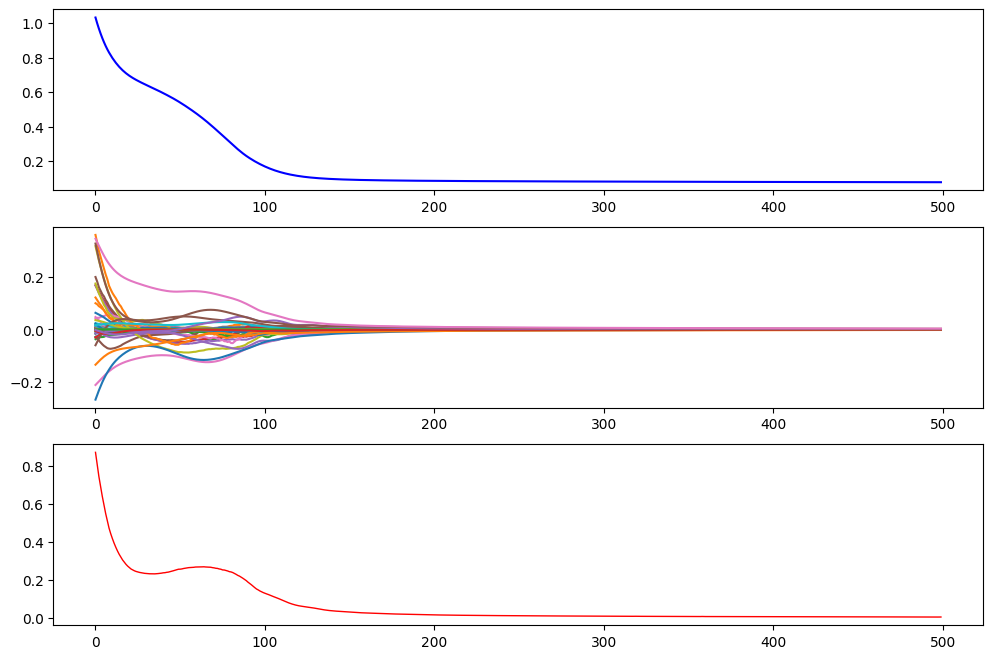

In [33]:
## PLOT PARA OBSERVAR COMO VARÍA EL LOSS A LO LARGO DE LAS EPOCAS, LOS GRADIENTES DE TODOS LOS PARAMETROS DEL MODELO Y LA NORMA DEL VECTOR GRADIENTE

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 2, figure=fig)    

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(range(max_epochs), history, c="blue")

ax2 = fig.add_subplot(gs[1, :])
for p in nn.parameters():
    ax2.plot(range(max_epochs), grads[id(p)])

ax3 = fig.add_subplot(gs[2, :])
ax3.plot(range(max_epochs), grad_norm_list, "r", linewidth=1)
plt.show()

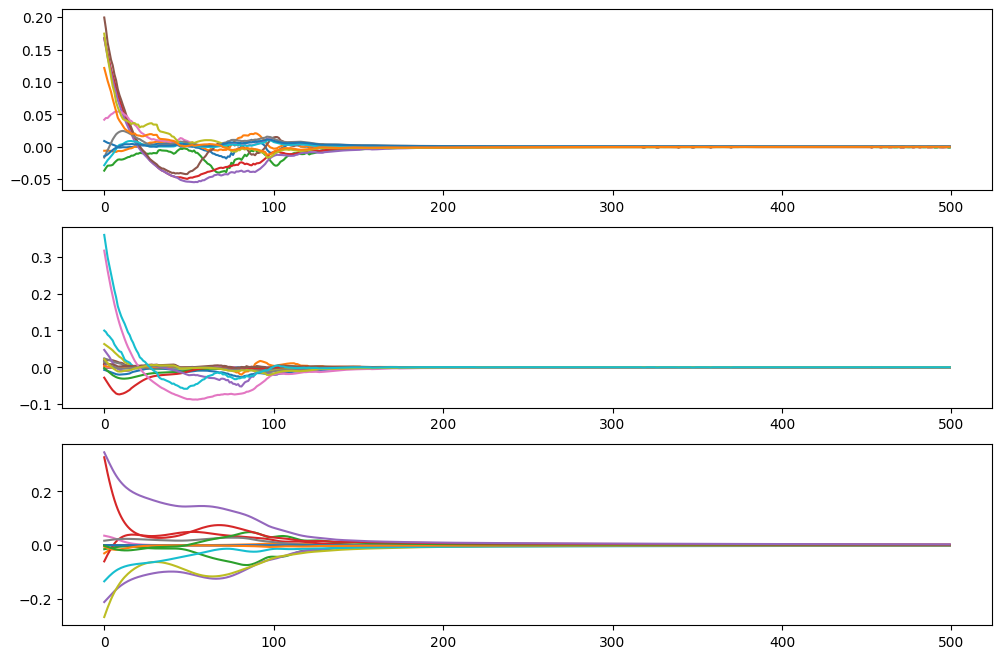

In [34]:
## PLOT PARA OBSERVAR COMO VARÍAN LOS GRADIENTES POR CAPA A LO LARGO DE LAS EPOCAS

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(len(nn.layers), 2, figure=fig)
for i, layer in enumerate(nn.layers):
    ax = fig.add_subplot(gs[i, :])
    for p in layer.parameters():
        ax.plot(range(max_epochs), grads_layer[id(layer)][id(p)])
plt.show()

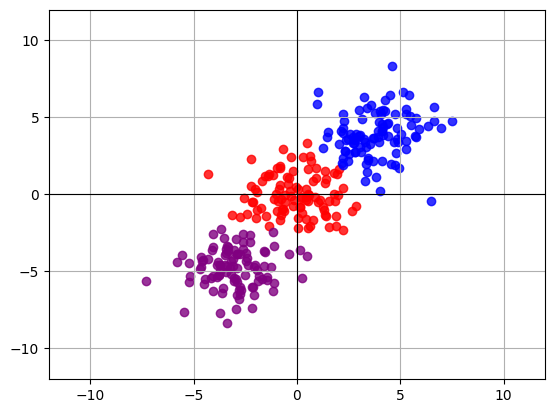

In [36]:
## PLOT PARA OBSERVAR COMO CLASIFICA LA RED NEURONAL

preds = []
for x in X_norm:
    yp = nn(x)
    yp_argmax = np.argmax(yp)
    preds.append(yp_argmax)
    
preds = np.asarray(preds)
yp_0 = preds[preds == 0]
yp_1 = preds[preds == 1]
yp_2 = preds[preds == 2]


X = np.asarray(X)
Xpred_0 = X[preds == 0]
Xpred_1 = X[preds == 1]
Xpred_2 = X[preds == 2]


plt.scatter(Xpred_0[:, 0], Xpred_0[:, 1], c="red", alpha=0.8)
plt.scatter(Xpred_1[:, 0], Xpred_1[:, 1], c="blue", alpha=0.8)
plt.scatter(Xpred_2[:, 0], Xpred_2[:, 1], c="purple", alpha=0.8)
plt.xlim((-12, 12))
plt.ylim((-12, 12))
plt.grid()
plt.vlines(0, -15, 15, colors="k", linewidth=0.8)
plt.hlines(0, -15, 15, colors="k", linewidth=0.8)
plt.show()

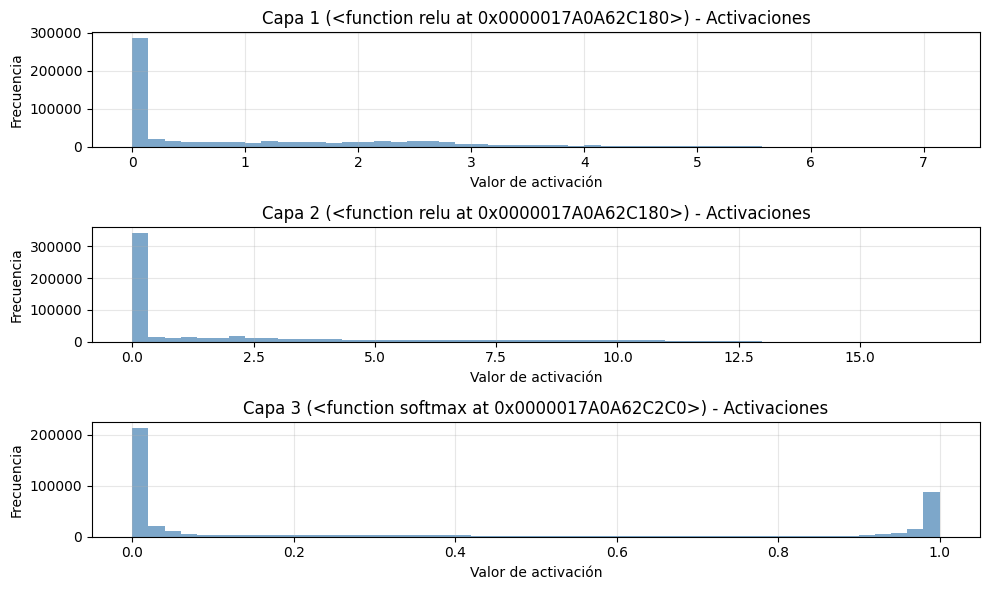

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(len(nn.layers), 1, figsize=(10, 2 * len(nn.layers)))
if len(nn.layers) == 1:
    axs = [axs]

for i, layer in enumerate(nn.layers):
    acts = np.concatenate(activations_per_layer[id(layer)])  # aplanamos
    axs[i].hist(acts, bins=50, color='steelblue', alpha=0.7)
    axs[i].set_title(f"Capa {i+1} ({layer.act_func}) - Activaciones")
    axs[i].set_xlabel("Valor de activación")
    axs[i].set_ylabel("Frecuencia")
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
x_min, x_max = -12, 12
y_min, y_max = -12, 12

h = 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.zeros(xx.shape)

for i in range(xx.shape[0]):
    for j in range(yy.shape[1]):
        x_input = [xx[i, j], yy[i, j]]
        y_pred = nn(x_input)
        Z[i, j] = np.argmax([y.data for y in y_pred])

In [ ]:
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")

X = np.asarray(X)
y = np.asarray(y)

y_class = np.argmax(y, axis=1)
plt.scatter(X[:, 0], X[:, 1], c=y_class, cmap="viridis", edgecolor="k", alpha=0.8)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.title("Fronteras de decisión aprendidas por el MLP")
plt.show()